Part 1

In [54]:
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import optim
from torch import nn
from scipy.stats import kendalltau, spearmanr
from sklearn.preprocessing import OneHotEncoder
from IPython.display import clear_output

In [55]:
TOP_N = 20  # number of top players and tournaments to consider
N_EPOCHS = 10  # number of epochs to train the model

In [56]:
if not os.path.exists("/content/chgk.zip"):
    !rm -rf chgk.zip
    !wget -q https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip
    !unzip -oq chgk.zip

In [57]:
players = pd.read_pickle("/content/players.pkl")
players = pd.DataFrame.from_dict(players, orient="index")

In [58]:
players.head()

,id,name,patronymic,surname
1,1,Алексей,None,Абабилов
10,10,Игорь,,Абалов
11,11,Наталья,Юрьевна,Абалымова
12,12,Артур,Евгеньевич,Абальян
13,13,Эрик,Евгеньевич,Абальян


In [59]:
tournaments = pd.read_pickle("/content/tournaments.pkl")
tournaments = pd.DataFrame.from_dict(tournaments, orient="index")

In [60]:
tournaments.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
1,1,Чемпионат Южного Кавказа,2003-07-25T00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,2,Летние зори,2003-08-09T00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,3,Турнир в Ижевске,2003-11-22T00:00:00+03:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,4,Чемпионат Украины. Переходной этап,2003-10-11T00:00:00+04:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,5,Бостонское чаепитие,2003-10-10T00:00:00+04:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None


In [61]:
min_start_date = tournaments["dateStart"].min().split('T')[0]
max_start_date = tournaments["dateStart"].max().split('T')[0]

print(f"Minimum tournament start date: {min_start_date}.")
print(f"Maximum tournament start date: {max_start_date}.")

Minimum tournament start date: 1992-09-08.
Maximum tournament start date: 2021-03-05.


In [62]:
min_end_date = tournaments["dateEnd"].min().split('T')[0]
max_end_date = tournaments["dateEnd"].max().split('T')[0]

print(f"Minimum tournament end date: {min_end_date}.")
print(f"Maximum tournament end date: {max_end_date}.")

Minimum tournament end date: 1992-09-10.
Maximum tournament end date: 2021-03-07.


In [63]:
results = pd.read_pickle("/content/results.pkl")

In [64]:
def build_dataset(year):
    data = defaultdict(list)

    for num, teams in results.items():
        tournament_year = int(tournaments.at[num, "dateStart"].split('-')[0])
        for team in teams:
            for member in team["teamMembers"]:
                if tournament_year == year and team.get("mask", None):
                    data[num].append({
                        "tournament_id": num,
                        "tournament_name": tournaments.at[num, "name"],
                        "team_id": team["team"]["id"],
                        "team_name": team["team"]["name"],
                        "questions_mask": team.get("mask", None),
                        "questionQty": tournaments.at[num, "questionQty"],
                        "position": team.get("position", None),
                        "player_id": member["player"]["id"],
                        "player_name": member["player"]["surname"] + " " + \
                                       member["player"]["name"]
                    })
    return data

In [65]:
train_data = build_dataset(2019)
test_data = build_dataset(2020)

In [66]:
data_cleaned = defaultdict(list)
errors = []

for tournament_id, teams in train_data.items():
    for team in teams:
        if len(team["questions_mask"]) == sum(team["questionQty"].values()):
            data_cleaned[tournament_id].append(team)
        else:
            errors.append(str(tournament_id))

train_data = data_cleaned

print(f"Number of teams with mismatched question masks: " \
      f"{len(errors)}.")
print(f"Number of tournaments with mismatched team question masks: " \
      f"{len(set(errors))}.")
print("IDs of tournaments with mismatched team question masks:")
print(', '.join(sorted(set(errors))))

Number of teams with mismatched question masks: 37040.
Number of tournaments with mismatched team question masks: 12.
IDs of tournaments with mismatched team question masks:
5462, 5553, 5554, 5703, 5760, 5864, 6026, 6085, 6090, 6249, 6254, 6255


In [67]:
print(f"Unique tournaments in train data: {len(train_data)}.")
print(f"Unique tournaments in test data: {len(test_data)}.")

Unique tournaments in train data: 675.
Unique tournaments in test data: 173.


In [68]:
train_data = [x for _, v in train_data.items() for x in v]
test_data = [x for _, v in test_data.items() for x in v]

In [69]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [70]:
train_df.shape[0], test_df.shape[0]

(414743, 112841)

In [71]:
train_df["tournament_id"].nunique(), test_df["tournament_id"].nunique()

(675, 173)

In [72]:
train_df.head()

,tournament_id,tournament_name,team_id,team_name,questions_mask,questionQty,position,player_id,player_name
0,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,6212,Выменец Юрий
1,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,18332,Либер Александр
2,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,18036,Левандовский Михаил
3,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,22799,Николенко Сергей
4,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,15456,Коновалов Сергей


In [73]:
# We won't need results anymore, so let's clear RAM:
del results
del train_data
del test_data

Part 2

In [74]:
qa_data = {
    "question_id": [],
    "player_id": [],
    "team_id": [],
    "tournament_id": [],
    "answer_label": [],
}

for tournament_id, team_id, player_id, mask in zip(train_df["tournament_id"],
                                                   train_df["team_id"],
                                                   train_df["player_id"],
                                                   train_df["questions_mask"]):
    for index, value in enumerate(mask):
        if value not in ["X", "?"]:
            qa_data["tournament_id"].append(tournament_id)
            qa_data["team_id"].append(team_id)
            qa_data["question_id"].append(f"{tournament_id}_{index}")
            qa_data["player_id"].append(player_id)
            qa_data["answer_label"].append(int(value))

In [75]:
qa_data_df = pd.DataFrame(qa_data)

In [76]:
# Decrease RAM consuming and get some speedup
# by changing types from int64 to smaller ones:
qa_data_df = qa_data_df.astype(dtype={
    "player_id": np.uint32,
    "team_id": np.uint32,
    "tournament_id": np.uint32,
    "answer_label": np.uint8
})

qa_data = qa_data_df.copy()

In [77]:
qa_data_df.head()

,question_id,player_id,team_id,tournament_id,answer_label
0,4772_0,6212,45556,4772,1
1,4772_1,6212,45556,4772,1
2,4772_2,6212,45556,4772,1
3,4772_3,6212,45556,4772,1
4,4772_4,6212,45556,4772,1


In [78]:
qa_data_df.shape

(17739658, 5)

Произведём One Hot преобразование идентификаторов игроков и вопросов, чтобы параметры модели представляли собой вектор $\omega = (S_1, S_2, ..., S_n, q_1, q_2, ..., q_M, \mu )$, где $N$ — общее количество игроков, $M$ — общее количество вопросов. Таким образом, модель будет учитывать "силы" игроков $S_i$
 и сложность вопросов $q_j$. Здесь $\mu$ — глобальная константа.

In [79]:
encoder = OneHotEncoder()

train_data = encoder.fit_transform(
    qa_data_df[["player_id", "question_id"]]
)

Определим модель и $M$-шаг. На $M$-шаге происходит простое обучение модели при заданных "силах" игроков и сложностях вопросов с уточнением параметров модели.

In [80]:
class LogisticRegression(nn.Module):
    def __init__(self, n_features):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        out = self.sigmoid(x)
        return out

In [81]:
def m_step(model, x, y_true, lr=3e-4, n_iter=100):
    model.fc.reset_parameters()
    loss_func = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr)

    for i in range(n_iter):
        opt.zero_grad()
        y_pred = model(x)
        loss = loss_func(y_pred, y_true)
        loss.backward()
        opt.step()

Обучим модель предсказывать событие $z_{ij}$, соответствующее тому, что игрок $i$ ответил на вопрос $j$.

При этом будем пользоваться следующим предположением: если команда $t$ ответила на вопрос $j$ (событие $x_{ij}$), то и каждый её член ответил на этот вопрос, и наоборот, если команда не ответила на вопрос — значит, ни один её член не ответил на вопрос.

Тогда:

$p(z_{ij} = 1) = p(x_{ij} = 1) = \sigma(\mu + S_i + q_j)$

Поскольку метки для $p(x_{ij} = 1)$ имеются в нашем тренировочном наборе данных, можно приступать к моделированию.

In [82]:
train_data = train_data.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train_data.row, train_data.col))),
    torch.FloatTensor(train_data.data)
)

y = torch.FloatTensor(qa_data_df["answer_label"].values).view(-1, 1)

model = LogisticRegression(x.shape[1])

In [83]:
m_step(model, x, y, lr=1, n_iter=100)

Введём функцию для вывода топ-$n$ игроков на основании их силы, полученной из модели:

In [84]:
def get_top_players(parameters, top_n=20):
    player_weights = {}

    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]

    top_players = sorted([(k, v) for k, v in player_weights.items()],
                         reverse=True, key=lambda x: x[1])[:top_n]

    df_top_players = {
        "player_id": [],
        "surname": [],
        "name": [],
        "skill": [],
        "place": [],
    }

    for place, (id, skill) in enumerate(top_players):
        df_top_players["player_id"].append(id)
        df_top_players["surname"].append(players.at[id, "surname"])
        df_top_players["name"].append(players.at[id, "name"])
        df_top_players["skill"].append(skill)
        df_top_players["place"].append(place + 1)

    df_top_players = pd.DataFrame(df_top_players)

    return df_top_players

Сравним позиции игроков на основе полученного рейтинга с реальными позициями на дату 26 декабря 2019 года:

In [85]:
df_top_players = get_top_players(model.fc.weight.data[0].numpy(), TOP_N)
df_top_players

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,player_id,surname,name,skill,place
0,27403,Руссо,Максим,3.368130,1
1,4270,Брутер,Александра,3.229891,2
2,28751,Семушин,Иван,3.182182,3
3,27822,Савченков,Михаил,3.104925,4
4,30270,Спешков,Сергей,3.026838,5
5,30152,Сорожкин,Артём,3.019893,6
6,40411,Кудинов,Дмитрий,3.015554,7
7,38175,Пилипенко,Максим,2.949709,8
8,20691,Мереминский,Станислав,2.919009,9
9,202410,Подюкова,Валентина,2.873866,10


In [90]:
df_real_top_players = pd.read_csv("/content/players-release-2019-12-26.csv")

df_real_top_players = df_real_top_players.rename(columns={
    " ИД": "player_id",
    "Фамилия": "surname",
    "Имя": "name",
    "Место": "real_place",
    "Рейтинг": "real_rating",
})[["player_id", "real_rating", "real_place"]]

df_real_top_players.head(TOP_N)

,player_id,real_rating,real_place
0,30152,14897,1
1,28751,14789,2
2,27822,14726,3
3,30270,14624,4
4,27403,14311,5
5,4270,14309,6
6,18332,14115,7
7,7008,13954,8
8,6212,13903,9
9,15456,13903,10


In [91]:
df_top_players.join(df_real_top_players.set_index("player_id"), on="player_id") \
    .fillna(0) \
    .astype(dtype={
        "real_rating": np.uint32,
        "real_place": np.uint32
    })

,player_id,surname,name,skill,place,real_rating,real_place
0,27403,Руссо,Максим,3.368130,1,14311,5
1,4270,Брутер,Александра,3.229891,2,14309,6
2,28751,Семушин,Иван,3.182182,3,14789,2
3,27822,Савченков,Михаил,3.104925,4,14726,3
4,30270,Спешков,Сергей,3.026838,5,14624,4
5,30152,Сорожкин,Артём,3.019893,6,14897,1
6,40411,Кудинов,Дмитрий,3.015554,7,5507,6879
7,38175,Пилипенко,Максим,2.949709,8,3445,11063
8,20691,Мереминский,Станислав,2.919009,9,12388,171
9,202410,Подюкова,Валентина,2.873866,10,0,0


Как можно заметить, ранжирование некоторых игроков очень близко к реальному рейтингу, хотя доля игроков, отсутствуюших в реальном рейтинге, также велика.

Part 3

Силу команды будем трактовать как вероятность того, что хотя бы один её член ответит на вопрос средней сложности.

$$\displaystyle t_i = 1 - \prod_{j=1}^{N}{(1 - \sigma(\mu + S_{ij} + q_{mean}))}$$

где:<br>
* $S_{ij}$ — сила игрока $j$ в команде $i$,
* $N$ — количество игроков в команде $i$,
* $q_{mean}$ — вопрос средней сложности,
* $\mu$ — глобальная константа.

In [93]:
def calc_metrics(data, encoder, parameters, intercept):
    player_weights = {}
    count = 0
    question_sum = 0
    player_sum = 0
    player_cnt = 0
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
            player_sum += parameters[i]
            player_cnt += 1
        else:
            question_sum += parameters[i]
            count += 1
    question_mean = question_sum / count
    data["player_weights"] = data["player_id"].map(player_weights)
    data["player_weights"].fillna(player_sum / player_cnt, inplace=True)
    data["players_proba"] = data["player_weights"].apply(
        lambda x: 1 / (1 + np.exp(-(x + question_mean + intercept)))
    )
    probas = data.groupby(["tournament_id", "team_id"])["players_proba"].apply(
        lambda x: np.prod(1 - x)
    )
    position = data.groupby(["tournament_id", "team_id"])["position"].first()
    group_data = pd.concat([probas, position], axis=1)
    group_data.sort_values(["tournament_id", "players_proba"],
                           ascending=[True, True], inplace=True)
    spearman = group_data.groupby("tournament_id").apply(
        lambda x: spearmanr(x["position"], x["players_proba"]).correlation
    ).mean()
    kendall = group_data.groupby("tournament_id").apply(
        lambda x: kendalltau(x["position"], x["players_proba"]).correlation
    ).mean()
    return spearman, kendall

In [94]:
spearman, kendall = calc_metrics(test_df, encoder,
                                 model.fc.weight.data[0].numpy(),
                                 model.fc.bias.data[0].numpy())
print(f"Spearman: {spearman:.6f}")
print(f"Kendall:  {kendall:.6f}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Spearman: 0.785997
Kendall:  0.629094


Part 4

Заметим следующее:
1. если хотя бы один из игроков команды ответил на вопрос, то и вся команда ответила на вопрос;
2. если команда не ответила на вопрос, то и все её члены не ответили на вопрос;
3. игроки отвечают на вопрос независимо.

Теперь будем моделировать вероятность того, что игрок $i$ ответил на вопрос $j$, при условии, что команда игрока $i$ ответила на этот вопрос:
$$p(z_{ij}=1|t_i=1)$$

Согласно второму замечанию, если команда не ответила на вопрос, то и ни один её игрок не ответил (либо команда отвергла правильный ответ, что в некотором смысле почти то же самое):
$$p(z_{ij}=1|t_i=0) = 0$$

В таком случае воспользуемся теоремой Байеса:
$$\displaystyle p(z_{ij}=1|t_i=1) = \frac{p(t_i=1|z_{ij}=1)p(z_{ij}=1)}{p(t_i=1)}$$

Мы знаем, что:
* $p(t_i=1|z_{ij}=1) = 1$ согласно второму предположению выше;
* $p(z_{ij}=1) = \sigma(\mu + S_i + q_j)$ — предсказание модели на $M$-шаге;
* $\displaystyle p(t_i=1) = 1 - \prod_{k=1}^{N}{(1 - \sigma(\mu + S_{ik} + q_{j}))}$ — вероятность команды ответить на вопрос равна разности единицы и произведения вероятностей того, что каждый игрок команды не ответит на вопрос.

Тогда:
$$\displaystyle p(z_{ij}=1|t_i=1) = \frac{\sigma(\mu + S_i + q_j)}{1 - \prod_{k=1}^{N}{(1 - \sigma(\mu + S_{ik} + q_{j}))}}$$

Это и будет являться $E$-шагом. Реализуем его в коде:

In [95]:
def e_step(data, predicts):
    data["label"] = predicts
    data.loc[data["answer_label"] == 0, "label"] = 0
    idx = data["answer_label"] == 1
    sp = data.loc[idx].groupby(["team_id", "question_id"])["label"].transform(
        lambda x: 1 - np.prod(1 - x.values)
    )
    data.loc[idx, "label"] = data.loc[idx, "label"] / sp  
    return data

Epoch: 10
    Spearman: 0.801505
    Kendall:  0.646282


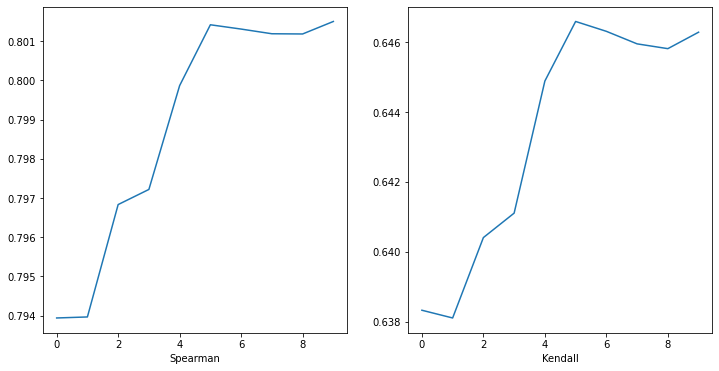

In [96]:
predicts = model(x).detach().numpy().ravel()

spearman_metric = []
kendall_metric = []

for i in range(N_EPOCHS):
    qa_data_df = e_step(qa_data_df, predicts)
    y = torch.FloatTensor(qa_data_df["label"].values).view(-1, 1)
    m_step(model, x, y, lr=1, n_iter=100)
    torch.save(model.state_dict(), f"model_{i}.pth")
    predicts = model(x).detach().numpy().ravel()
    spearman, kendall = calc_metrics(test_df, encoder,
                                     model.fc.weight.data[0].numpy(),
                                     model.fc.bias.data[0].numpy())
    spearman_metric.append(spearman)
    kendall_metric.append(kendall)
    clear_output(True)
    print(f"Epoch: {i + 1}")
    print(f"    Spearman: {spearman:.6f}")
    print(f"    Kendall:  {kendall:.6f}")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(spearman_metric)
    ax[0].set_xlabel("Spearman")
    ax[1].plot(kendall_metric)
    ax[1].set_xlabel("Kendall")
    plt.show()

Part 5

Для простоты будем считать, что сложность турнира — это средняя сложность вопросов в нём.

In [97]:
parameters = model.fc.weight.data[0].numpy()

question_weights = {}
for i, c in enumerate(encoder.get_feature_names()):
    if c.startswith("x1_"):
        question_weights[c[3:]] = parameters[i]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [98]:
tournament_weights = qa_data_df.groupby("tournament_id")["question_id"] \
    .apply(lambda x: np.mean([question_weights[q] for q in x])) \
    .sort_values()

In [99]:
tournament_weights = tournament_weights.reset_index().rename(columns={
    "question": "difficulty"
})

In [100]:
print(f"Top {TOP_N} most difficult tournaments:")
tournament_weights.head(TOP_N).merge(
    tournaments[["id", "name"]].set_index("id"),
    left_on="tournament_id", right_on="id",
)

Top 20 most difficult tournaments:


,tournament_id,question_id,name
0,6149,-7.498530,Чемпионат Санкт-Петербурга. Первая лига
1,5717,-3.633842,Чемпионат Таджикистана
2,5928,-3.162831,Угрюмый Ёрш
3,5930,-3.117624,Зеркало мемориала памяти Михаила Басса
4,5684,-3.094594,Синхрон высшей лиги Москвы
5,6101,-3.086806,Воображаемый музей
6,5159,-2.927777,Первенство правого полушария
7,5943,-2.924603,Чемпионат Мира. Этап 2 Группа С
8,5942,-2.775042,Чемпионат Мира. Этап 2. Группа В
9,5532,-2.758197,Седьмая октава: Кубок Равноденствия. Лига Наци...


In [101]:
print(f"Top {TOP_N} least difficult tournaments:")
tournament_weights.tail(TOP_N).merge(
    tournaments[["id", "name"]].set_index("id"),
    left_on="tournament_id", right_on="id",
)

Top 20 least difficult tournaments:


,tournament_id,question_id,name
0,5697,1.392844,Школьный Синхрон-lite. Выпуск 3.1
1,5601,1.397188,Межфакультетский кубок МГУ. Отбор №4
2,5702,1.398867,(а)Синхрон-lite. Лига старта. Эпизод IX
3,5535,1.411484,Кубок Тышкевичей
4,6254,1.447329,Школьная лига
5,5954,1.517706,Школьная лига. II тур.
6,5012,1.571946,Школьный Синхрон-lite. Выпуск 2.5
7,5388,1.608304,Олимпиада Приволжского федерального округа. Финал
8,5013,1.612890,(а)Синхрон-lite. Лига старта. Эпизод V
9,6003,1.624782,Второй тематический турнир имени Джоуи Триббиани


Part 6

Посмотрим на количество вопросов, на которые ответил каждый игрок из топ-20, и количество турниров, в которых игрок поучаствовал:

In [102]:
questions_per_player = qa_data_df \
    .groupby("player_id")["question_id"] \
    .nunique()

tournaments_per_player = qa_data_df \
    .groupby("player_id")["tournament_id"] \
    .nunique()

In [103]:
df_top_players = get_top_players(model.fc.weight.data[0].numpy(), TOP_N)

df_top_players["num_tournaments"] = df_top_players["player_id"].apply(
    lambda x: tournaments_per_player[x]
)

df_top_players["num_questions"] = df_top_players["player_id"].apply(
    lambda x: questions_per_player[x]
)

df_top_players

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,player_id,surname,name,skill,place,num_tournaments,num_questions
0,38175,Пилипенко,Максим,3.248625,1,1,36
1,22474,Немец,Илья,3.115344,2,2,75
2,14996,Козлова,Ольга,2.658051,3,1,36
3,199963,Бровченко,Елена,2.642691,4,1,36
4,202410,Подюкова,Валентина,2.568417,5,1,36
5,40411,Кудинов,Дмитрий,2.471855,6,1,45
6,188876,Голудина,Мария,2.444933,7,1,36
7,33459,Фрайман,Феликс,2.433311,8,1,36
8,17750,Лазарева,Галина,2.355114,9,1,36
9,199115,Королихин,Анатолий,2.296140,10,1,30


In [104]:
qa_data_df = qa_data.copy()

In [105]:
qa_data_df["num_tournaments"] = qa_data_df["player_id"].apply(
    lambda x: tournaments_per_player[x]
)

qa_data_df["num_questions"] = qa_data_df["player_id"].apply(
    lambda x: questions_per_player[x]
)

In [106]:
questions_threshold = qa_data_df["num_questions"].quantile(0.2)
questions_threshold

285.0

Такой порог будет соответствовать необходимости отыграть примерно 6-10 турниров. Это довольно много, но давайте посмотрим, что произойдёт с поведением модели:

In [107]:
qa_data_df = qa_data_df[qa_data_df["num_questions"] > questions_threshold]

In [108]:
qa_data_df.shape

(14185333, 7)

In [110]:
encoder = OneHotEncoder()

train_data = encoder.fit_transform(
    qa_data_df[["player_id", "question_id"]]
)

In [111]:
train_data = train_data.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train_data.row, train_data.col))),
    torch.FloatTensor(train_data.data)
)

y = torch.FloatTensor(qa_data_df["answer_label"].values).view(-1, 1)

model = LogisticRegression(x.shape[1])

Epoch: 10
    Spearman: 0.676068
    Kendall:  0.533970


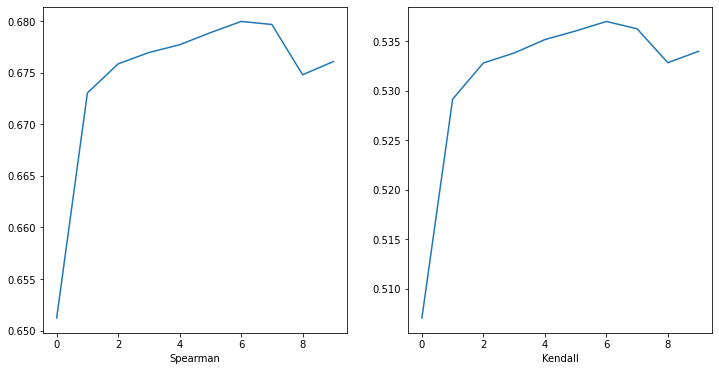

In [112]:
predicts = model(x).detach().numpy().ravel()

spearman_metric = []
kendall_metric = []

for i in range(N_EPOCHS):
    qa_data_df = e_step(qa_data_df, predicts)
    y = torch.FloatTensor(qa_data_df["label"].values).view(-1, 1)
    m_step(model, x, y, lr=1, n_iter=100)
    torch.save(model.state_dict(), f"model_filtered_{i}.pth")
    predicts = model(x).detach().numpy().ravel()
    spearman, kendall = calc_metrics(test_df, encoder,
                                     model.fc.weight.data[0].numpy(),
                                     model.fc.bias.data[0].numpy())
    spearman_metric.append(spearman)
    kendall_metric.append(kendall)
    clear_output(True)
    print(f"Epoch: {i + 1}")
    print(f"    Spearman: {spearman:.6f}")
    print(f"    Kendall:  {kendall:.6f}")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(spearman_metric)
    ax[0].set_xlabel("Spearman")
    ax[1].plot(kendall_metric)
    ax[1].set_xlabel("Kendall")
    plt.show()

Как и ожидалось, метрики модели значительно ухудшились.